# Numerical Optimization and Large Scale Linear Algebra
## Assignment 1 - House price prediction
### Instructor: P. Vassalos

**Student:** Phevos A. Margonis - f3352317

**Date:** 16/Feb/2024


In [73]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split

df = pd.read_excel("housedata.xls", "Sheet1")

In [74]:
# %% Preprocess
df.columns = ["location", "bedrooms", "bathrooms", "area", "condo", "price"]
# location: Encoded ZIP code areas
# bedrooms: Number of bedrooms
# bathrooms: Number of bathrooms
# area: House's area in 1000 squre feet
# condo: Boolean value denoteting if house is a condominium
# price: Selling price

df.price = df.price.astype(str)
df.price = df.price.str.replace(r"\D", "", regex=True).astype(int)
df.head()

,location,bedrooms,bathrooms,area,condo,price
0,2,2,2,941,1,94905
1,2,3,2,1146,0,98937
2,2,3,2,909,0,100309
3,3,3,2,1289,0,106250
4,3,3,1,1020,0,107502


In [75]:
# %% Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    df[["area", "bedrooms"]], df[["price"]], train_size=695, random_state=4568
)

## Model 1
---

y = 150.68 x1 + -17351.98 x2 + 48124.61


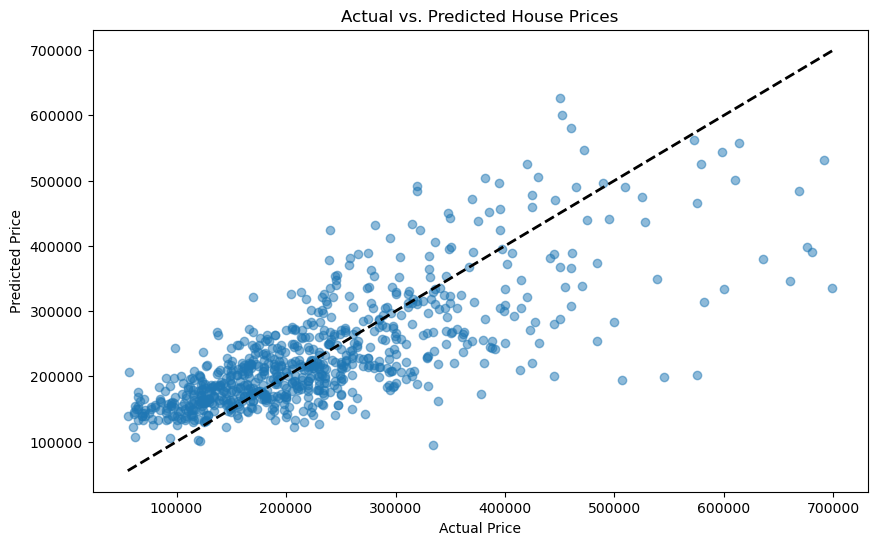

In [76]:
# %% Model 1: area, bedrooms
modelA = LinearRegression()
modelA.fit(X_train, y_train)
print(f"y = {modelA.coef_[0][0]:.2f} x1 + {modelA.coef_[0][1]:.2f} x2 + {modelA.intercept_[0]:.2f}")

# Predict prices for all homes based on the model fit on the training portion
y_all_pred = modelA.predict(df[["area", "bedrooms"]])

# 2. Creating a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df.price, y_all_pred, alpha=0.5)  # Actual vs Predicted
plt.title("Actual vs. Predicted House Prices")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
# Diagonal line representing perfect predictions
plt.plot(
    [df.price.min(), df.price.max()], [df.price.min(), df.price.max()], "k--", lw=2
)
plt.show()

The above graph reveals a slight non-linearity in the lower-end predictions along with an increasing variance as the target varialbe increases.

In [77]:
# %%
# 3. Test on external data
testdf = pd.DataFrame(
    {
        "house": [1, 2, 3, 4, 5],
        "area": [846, 1324, 1150, 3037, 3984],
        "bedrooms": [1, 2, 3, 4, 5],
        "price": [115000, 234500, 198000, 528000, 572500],
    }
)
testdf.set_index("house", inplace=True)

# Calculate mean squared error
mse = mean_squared_error(testdf.price, modelA.predict(testdf[["area", "bedrooms"]]))
rmse = np.sqrt(mse)
print(f"RMSE (Train+Test) for Model A: {rmse:.2f}$")

RMSE (Train+Test) for Model A: 48330.47$


In [78]:
# %% 4. RMSE for Training and RMSE for Test data
mse = mean_squared_error(y_train, modelA.predict(X_train))
rmse_train = np.sqrt(mse)
mse = mean_squared_error(y_test, modelA.predict(X_test))
rmse_test = np.sqrt(mse)

print(f"Train RMSE: {rmse_train:.2f}")
print(f"Test RMSE: {rmse_test:.2f}")
print(f"Absolute deviation of Train-Test RMSE: {np.abs(rmse_train-rmse_test):.2f}$\n")

Train RMSE: 75476.13
Test RMSE: 69619.90
Absolute deviation of Train-Test RMSE: 5856.22$



The Train RMSE and the Test RMSE are not particularly close to each other. Thus, along with the findings of the above graph, the need arises for a better model.

## Model 2
---

In [79]:
# %% Model 2: 8 bases
# Create new values
newdf = pd.DataFrame(
    {
        "x1": np.ones(len(df)),
        "x2": df.area,
        "x3": df.area.sub(1500).clip(lower=0),
        "x4": df.bedrooms,
        "x5": df.condo,
    }
)
# Generate dummy variables
newdf = pd.concat(
    [newdf, pd.get_dummies(df.location, drop_first=True).astype(int)], axis=1
)
# Rename dummies
newdf = newdf.rename(columns={2: "x6", 3: "x7", 4: "x8"})
newdf.head()

,x1,x2,x3,x4,x5,x6,x7,x8
0,1.0,941,0,2,1,1,0,0
1,1.0,1146,0,3,0,1,0,0
2,1.0,909,0,3,0,1,0,0
3,1.0,1289,0,3,0,0,1,0
4,1.0,1020,0,3,0,0,1,0


In [80]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    newdf, df.price, train_size=695, random_state=4568
)

y = 122056.92 x1 + 164.28 x2 + -28.38 x3 + -13927.08 x4 + -17042.41 x5 + -105008.17 x6 + -114418.26 x7 + -25535.99 x8


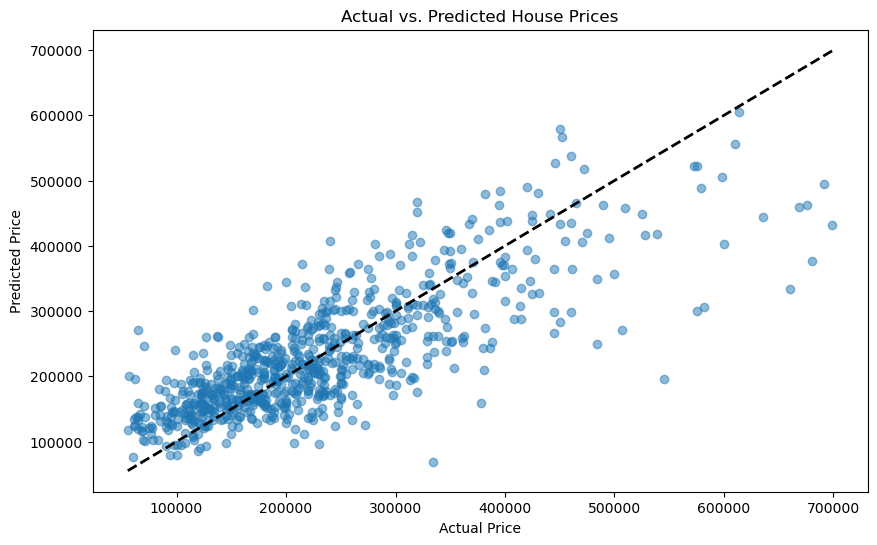

RMSE for Model B: 68249.66$


In [81]:
# Fit model
modelB = LinearRegression(fit_intercept=False)
modelB.fit(X_train_b, y_train_b)
print(f"y = {modelB.coef_[0]:.2f} x1 + {modelB.coef_[1]:.2f} x2 + {modelB.coef_[2]:.2f} x3 + {modelB.coef_[3]:.2f} x4 \
+ {modelB.coef_[4]:.2f} x5 + {modelB.coef_[5]:.2f} x6 + {modelB.coef_[6]:.2f} x7 + {modelB.coef_[7]:.2f} x8")

# Predict prices for all homes based on the model fit on the training portion
y_all_pred = modelB.predict(newdf)

# 2. Creating a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df.price, y_all_pred, alpha=0.5)  # Actual vs Predicted
plt.title("Actual vs. Predicted House Prices")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
# Diagonal line representing perfect predictions
plt.plot(
    [df.price.min(), df.price.max()], [df.price.min(), df.price.max()], "k--", lw=2
)
plt.show()
# RMSE

print(
    f"RMSE for Model B: {mean_squared_error(y_test_b, modelB.predict(X_test_b), squared=False):.2f}$"
)


The above graph reveals that the new model has improved upon the defects of the previous one by correcting the non-linearity and reigning in the increased variance on the upper end of the spectrum.

## Cross-validation
---
### Model 1:

In [82]:
# %% Cross-Validation model 1
modelC = LinearRegression()
# Perform K-Fold Cross-Validation
scores = cross_val_score(
    modelC,
    X=df[["area", "bedrooms"]],
    y=df[["price"]],
    cv=10,
    scoring="neg_root_mean_squared_error",
)

print(f"RMSE over 10 folds: {np.sqrt(np.mean(np.power(scores,2))):.2f} $")

RMSE over 10 folds: 76202.09 $


### Model 2:

In [83]:
# %% Cross-Validation model 2
modelD = LinearRegression(fit_intercept=False)
# Perform K-Fold Cross-Validation
scores = cross_val_score(
    modelD, X=newdf, y=df.price, cv=10, scoring="neg_root_mean_squared_error"
)

print(f"RMSE over 10 folds: {np.sqrt(np.mean(np.power(scores,2))):.2f} $")

RMSE over 10 folds: 70797.08 $


Using cross-validation, the improved performance of Model 2 becomes more apparent, providing greater confidence in the model's generalization.